# Test if TE's make good biomarkers for tissue samples
```
Andrew E. Davison
aedavids@ucsc.edu
6/1/23
```
**AIM 4 Hypothesis 1: A binary classifier can be trained using small set of intracellular differentially expressed TE's and repeats as features.**

**Method:**
We trained a logistic regression classifier with l2 regularization on our 309 Pancreas and Pancreatic adenocarcinoma GTEx and TCGA sample. We select use our DESeq 1vsAll analysis to reduce our feature space form74,777 to 18.

features
```
MER65-int MER65C LTR54B LTR81B MER65B
(GGT)n HERV30-int (TTCTCG)n (TGAA)n (TTCAT)n
(CCG)n (ACCAC)n (TACACA)n (GCC)n (GAGGC)n
(GCG)n (CGG)n (CTCCCT)n
```

**Preliminary Resutls:**
Our model accuracy on our training set is 0.964. This suggests that for each of our 83 tissue and cancer types we will be able low dimensional binary classifiers that work intracellular samples. This is a first step toward proving intracellular models can be use to classify extracellular samples. 

ref:
- extraCellularRNA/intraExtraRNA_POC/jupyterNotebooks/testIntraCellular-TE-BiomarkersOnExtracellularSamples.ipynb

In [1]:
# use display() to print an html version of a data frame
# useful if dataFrame output is not generated by last like of cell
from IPython.display import display

import joblib

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pathlib as pl

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression

import time    

# add our local python packages to path
import sys
sys.path.append('../python/src')
from confusion_matrix.cf_matrix import make_confusion_matrix
import intraExtraRNA.deseqUtilities as du
import intraExtraRNA.transposableElementUtilities as teu
import intraExtraRNA.utilities as ut

LOCAL_CACHE_DIR="/scratch/aedavids/tmp"
NOTEBOOK_NAME = "testIntraCellular-TE-Biomarkers"
imgOutPl = pl.Path("img/" + NOTEBOOK_NAME)
imgOutPl.mkdir(parents=True, exist_ok=True)

modelOutPL = pl.Path("models").joinpath(NOTEBOOK_NAME)
modelOutPL.mkdir(parents=True, exist_ok=True)

In [2]:
# common file paths
rootDir = "/private/groups/kimlab/GTEx_TCGA"
groupByDataDir = rootDir + "/groupbyGeneTrainingSets"
geneSignatureProfilesDir = rootDir + "/geneSignatureProfiles"

In [3]:
%%time 
# path to gene count file
trainGroupByGeneCountFilePath = groupByDataDir + "/GTEx_TCGA_TrainGroupby.csv"    
groupByGeneCountFilePath = ut.load(trainGroupByGeneCountFilePath, localCacheDir=LOCAL_CACHE_DIR, verbose=True)
groupedByGeneDF = pd.read_csv(groupByGeneCountFilePath, sep=",", index_col="geneId")

localTargetPath:
/scratch/aedavids/tmp/private/groups/kimlab/GTEx_TCGA/groupbyGeneTrainingSets/GTEx_TCGA_TrainGroupby.csv

CPU times: user 5min 47s, sys: 21.9 s, total: 6min 9s
Wall time: 6min 16s


In [4]:
groupedByGeneDF.head()#.loc[:, ["geneId"]]

,GTEX-1117F-0226-SM-5GZZ7,GTEX-1117F-0526-SM-5EGHJ,GTEX-1117F-0726-SM-5GIEN,GTEX-1117F-2826-SM-5GZXL,GTEX-1117F-3226-SM-5N9CT,GTEX-111CU-0326-SM-5GZXO,GTEX-111CU-0426-SM-5GZY1,GTEX-111CU-0526-SM-5EGHK,GTEX-111CU-0626-SM-5EGHL,GTEX-111CU-0826-SM-5EGIJ,...,UVM-WC-A881-TP,UVM-WC-A882-TP,UVM-WC-A883-TP,UVM-WC-A884-TP,UVM-WC-A888-TP,UVM-WC-AA9E-TP,UVM-YZ-A980-TP,UVM-YZ-A983-TP,UVM-YZ-A984-TP,UVM-YZ-A985-TP
geneId,,,,,,,,,,,,,,,,,,,,,
(A)n,9,1,3,13,1,2,2,1,0,0,...,7,7,3,2,20,0,7,3,4,1
(AAA)n,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
(AAAAAAC)n,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
(AAAAAAG)n,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
(AAAAAAT)n,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
%%time
trainingColDataFilePath = groupByDataDir + "/GTEx_TCGA_TrainColData.csv"
colDataFilePath = ut.load(trainingColDataFilePath, localCacheDir=LOCAL_CACHE_DIR, verbose=True)
colDataDF = pd.read_csv(colDataFilePath, sep=",")

localTargetPath:
/scratch/aedavids/tmp/private/groups/kimlab/GTEx_TCGA/groupbyGeneTrainingSets/GTEx_TCGA_TrainColData.csv

CPU times: user 50 ms, sys: 167 µs, total: 50.2 ms
Wall time: 93.6 ms


In [6]:
%%time
oneVsAllDataDir = rootDir + "/1vsAll"    
estimatedScalingFactorsFilePath = oneVsAllDataDir + "/estimatedSizeFactors.csv"
scalingFactorsPath = ut.load(estimatedScalingFactorsFilePath, localCacheDir=LOCAL_CACHE_DIR, verbose=True)
scalingFactorDF = pd.read_csv(scalingFactorsPath, sep=",")

localTargetPath:
/scratch/aedavids/tmp/private/groups/kimlab/GTEx_TCGA/1vsAll/estimatedSizeFactors.csv

CPU times: user 6.85 ms, sys: 7.59 ms, total: 14.4 ms
Wall time: 34.9 ms


In [7]:
%%time
normalizedDF = du.normalize(groupedByGeneDF, scalingFactorDF)
print(normalizedDF.shape)

(15801, 74777)
CPU times: user 4.28 s, sys: 5.83 s, total: 10.1 s
Wall time: 10.1 s


In [8]:
pancDF = ut.selectSamples(colDataDF, normalizedDF, ['PAAD', 'Pancreas'])
print(pancDF.shape)
pancDF.head()

(304, 74777)


geneId,(A)n,(AAA)n,(AAAAAAC)n,(AAAAAAG)n,(AAAAAAT)n,(AAAAAC)n,(AAAAACA)n,(AAAAACC)n,(AAAAACT)n,(AAAAAG)n,...,tRNA-Ser-TCY,tRNA-Thr-ACA,tRNA-Thr-ACG,tRNA-Thr-ACY,tRNA-Trp-TGG,tRNA-Tyr-TAC,tRNA-Tyr-TAT,tRNA-Val-GTA,tRNA-Val-GTG,tRNA-Val-GTY
GTEX-111CU-0526-SM-5EGHK,0.394930,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GTEX-111YS-1226-SM-5EGGJ,0.393574,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GTEX-1128S-0826-SM-5GZZI,1.578834,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GTEX-11DXX-0926-SM-5H112,0.500841,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GTEX-11GSP-0426-SM-5A5KX,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Select the best PAAD TE biomarkers

In [9]:
# load our 1vsAll DESeq2 results
category = 'PAAD_vs_all.results'
resultsFile = '/private/groups/kimlab/GTEx_TCGA/1vsAll/' + category
resultsFile = ut.load(resultsFile, localCacheDir=LOCAL_CACHE_DIR, verbose=True)

resultsDF = du.loadDESEqResults(resultsFile, skiprows=7)
print(f'shape: {resultsDF.shape}')
resultsDF.head()

localTargetPath:
/scratch/aedavids/tmp/private/groups/kimlab/GTEx_TCGA/1vsAll/PAAD_vs_all.results

shape: (65406, 6)


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
name,,,,,,
CELA2B,1332.659848,13.266912,0.484407,27.387922,3.819727e-165,1.412612e-160
ENPP3,321.790901,-5.689927,0.222926,-25.523852,1.071664e-143,1.981613e-139
VILL,687.481732,3.114475,0.127290,24.467473,3.279913e-132,4.043259e-128
POU3F3,675.194100,-8.707841,0.364690,-23.877352,5.266121e-126,4.868792e-122
LRP2,1211.112568,-7.771070,0.330318,-23.525996,2.211008e-122,1.635350e-118


In [10]:
# bestGenesList geneId HUGO format.
# countDF gene ids are in in ENSG format or loci . ex. ENSG00000227232.5 and (AAAAAC)n
tx2GeneFile="/private/groups/kimlab/genomes.annotations/gencode.35/gencode.v35.ucsc.rmsk.tx.to.gene.csv"
tx2GeneFile = ut.load(tx2GeneFile, localCacheDir=LOCAL_CACHE_DIR, verbose=True)
tx2geneFilePath = pl.Path(tx2GeneFile)
tx2GeneDF, geneCodeGeneGeneIdList, transposableElementGeneIdList = teu.loadTx2Genes(tx2geneFilePath)

localTargetPath:
/scratch/aedavids/tmp/private/groups/kimlab/genomes.annotations/gencode.35/gencode.v35.ucsc.rmsk.tx.to.gene.csv



In [11]:
TEResultsDF = du.selectGenesOfInterest(resultsDF, transposableElementGeneIdList)
print(TEResultsDF.shape)

(7085, 6)


In [12]:
print(f'TEResultsDF.shape : {TEResultsDF.shape}')
bestDESeq2DF = du.selectBest(TEResultsDF, topN=20) 
print(f'shape: {bestDESeq2DF.shape}')

print('\ndo not be confused by descriptive stats for lfc. we filter using abs')
print('min abs > lfcThreshold')

colOrderList = ['baseMean', 'padj',  'absLog2FoldChange', 'log2FoldChange' ]
bestDESeq2DF.loc[:, colOrderList].describe()

print()
bestDESeq2DF

TEResultsDF.shape : (7085, 6)
significantDF.shape : (587, 6)
shape: (18, 7)

do not be confused by descriptive stats for lfc. we filter using abs
min abs > lfcThreshold



,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,absLog2FoldChange
name,,,,,,,
MER65-int,556.802099,2.620277,0.159134,16.465900,6.449572e-61,3.359409e-58,2.620277
MER65C,388.243641,-2.273490,0.161676,-14.062046,6.498001e-45,1.365393e-42,2.273490
LTR54B,248.402453,2.413262,0.110440,21.851371,7.543373e-106,2.789690e-102,2.413262
LTR81B,107.510997,-2.380125,0.172778,-13.775617,3.573173e-43,6.673892e-41,2.380125
MER65B,92.648220,-2.378561,0.211343,-11.254482,2.201159e-29,1.562443e-27,2.378561
(GGT)n,63.499961,2.455226,0.249545,9.838825,7.660054e-23,2.807573e-21,2.455226
HERV30-int,57.513456,-2.287672,0.170835,-13.391103,6.816047e-41,1.140593e-38,2.287672
(TTCTCG)n,26.734924,-2.315476,0.453745,-5.103038,3.342440e-07,1.632894e-06,2.315476
(TGAA)n,15.557119,-4.749464,0.391838,-12.120982,8.177310e-34,8.330944e-32,4.749464


In [13]:
#select row that match our best genes
bestTEGenesList = bestDESeq2DF.index.to_list()
print(' '.join(bestTEGenesList[0:5]))
print(' '.join(bestTEGenesList[5:10]))
print(' '.join(bestTEGenesList[10:15]))
print(' '.join(bestTEGenesList[15:]))

MER65-int MER65C LTR54B LTR81B MER65B
(GGT)n HERV30-int (TTCTCG)n (TGAA)n (TTCAT)n
(CCG)n (ACCAC)n (TACACA)n (GCC)n (GAGGC)n
(GCG)n (CGG)n (CTCCCT)n


## Run logistic regression

In [14]:
# select best genes
bestCounTmpDF = pancDF.loc[:, bestTEGenesList]
print(bestCounTmpDF.shape)

(304, 18)


In [25]:
selectSamples = colDataDF.loc[:, "sample_id"].isin(pancDF.index)
conditionList = colDataDF.loc[selectSamples, 'category'].tolist()

labelEncoder = LabelEncoder()
y = labelEncoder.fit_transform(conditionList)

# quick visual check
tmpDF = pd.DataFrame( {
    'cat':conditionList,
    'oneHot': y } )

display(tmpDF.groupby(by="cat").count())
display(tmpDF.head())
print()
tmpDF.tail()

,oneHot
cat,
PAAD,107
Pancreas,197


,cat,oneHot
0,Pancreas,1
1,Pancreas,1
2,Pancreas,1
3,Pancreas,1
4,Pancreas,1


,cat,oneHot
299,PAAD,0
300,PAAD,0
301,PAAD,0
302,PAAD,0
303,PAAD,0


In [16]:
XNP = bestCounTmpDF.values #.transpose()
print(XNP.shape)

(304, 18)


In [17]:
%%time
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
lrModel = LogisticRegression()
#             , penalty='l2' # regularization some penalities do not work with some solvers
# tol=0.0001
# lrModel.fit(XNP, y, C=1.0 
#             ,random_state=42           
#             ,solver='lbfgs' 
#             , max_iterint=100
#           )

scaler = StandardScaler().fit(XNP)
ScalerFilePath = modelOutPL.joinpath("standardScaler.data")
print(ScalerFilePath)
joblib.dump(scaler, ScalerFilePath)

XScaled = scaler.transform(XNP)

lrModel = lrModel.fit(XScaled, y)

models/testIntraCellular-TE-Biomarkers/standardScaler.data
CPU times: user 22.2 ms, sys: 3.82 ms, total: 26 ms
Wall time: 71.2 ms


In [18]:
# save the model
# add an attribute containing the list of feature names
lrModel.features = bestTEGenesList
modelFilePath = modelOutPL.joinpath("logisticRegresion.data")
joblib.dump(lrModel, modelFilePath)

['models/testIntraCellular-TE-Biomarkers/logisticRegresion.data']

In [19]:
yHat = lrModel.predict(XScaled)
print('{} Accuracy : {:.2f}'.format(lrModel, lrModel.score(XScaled, y)))

LogisticRegression() Accuracy : 0.96


In [20]:
confusion_matrix = confusion_matrix(y, yHat)
print(confusion_matrix)

[[ 98   9]
 [  2 195]]


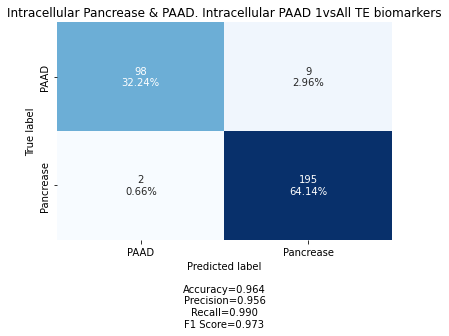

In [28]:
labels = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
#categories = ['Zero', 'One']
categories = ['PAAD', 'Pancrease'] 
title = "Intracellular Pancrease & PAAD. Intracellular PAAD 1vsAll TE biomarkers"
fig,panel = make_confusion_matrix(confusion_matrix, 
                      # group_names=labels,
                      categories=categories, 
                      cbar=False,
                      count=True,
                      cmap='Blues',
                      title=title
                     )

In [22]:
imgFilePL = imgOutPl.joinpath(NOTEBOOK_NAME + "-ConfusionMatrix.png")
print(imgFilePL)
fig.savefig(imgFilePL, dpi=600, bbox_inches='tight', facecolor="white", transparent=True)

img/testIntraCellular-TE-Biomarkers/testIntraCellular-TE-Biomarkers-ConfusionMatrix.png
